# Example: Regression with `Adam`

In this notebook we demonstrate how to use the `Adam` optimizer to train an instance of the `QNNRegressor` to fit a logarithm.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebPQC
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss, VarianceLoss, get_variance_fac
from squlearn.optimizers import Adam

In [2]:
executor = Executor("statevector_simulator")

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

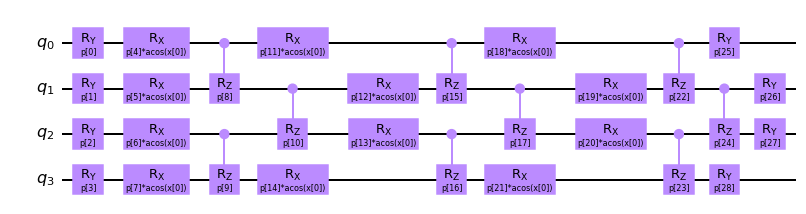

In [3]:
nqubits = 4
number_of_layers = 3

pqc = ChebPQC(nqubits, 1, num_layers=number_of_layers, closed=False)
pqc.draw("mpl")

We also need an observable

In [4]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `Adam` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator. For the `Adam` optimizer, we specify a maximum number of allowed iterations and a learning rate.

In [5]:
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters) * 4
param_op_ini = np.ones(cost_op.num_parameters)

ADAM = Adam({"maxiter": 50, "lr": 0.1})

reg = QNNRegressor(
    pqc,
    cost_op,
    executor,
    SquaredLoss(),
    ADAM,
    param_ini,
    param_op_ini,
    variance=get_variance_fac(0.005, 0.5, 5),
)

## Training

Now we are ready to train the model to fit the logarithm funciton

In [6]:
X = np.arange(0.1, 0.9, 0.1)
y = np.log(X)

reg.fit(X, y)

fit: 100%|██████████| 50/50 [05:43<00:00,  6.50s/it]

## Evaluation

Let's check the trained parameters of the PQC and operator

In [7]:
print("Result PQC params:", reg.param)
print("Result operator params:", reg.param_op)

Result PQC params: [ 1.85864558  2.40076555  2.16467602  3.3546674   2.95340035 -0.25131017
  2.61520484  1.95462771  1.53564032  2.14224606  0.40873856  0.94635988
  0.28752893  3.06449968  0.79523728  2.01949843  1.23289095  2.32095989
 -1.02290872  1.87518783  2.36921484  1.1406508   0.48471792  2.61125097
  0.41732844  1.22931963  1.91220113  2.61020691 -0.13337391]
Result operator params: [-0.66023726  0.50587425  0.42831288 -0.29429597  0.7918703 ]


Also let's plot the predicted function vs. the actual logarithm function

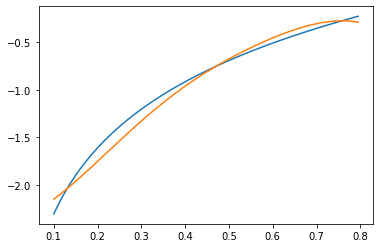

In [8]:
x = np.arange(np.min(X), np.max(X), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)